### 基于Gym中的21点游戏环境，试采用基于$\epsilon$-贪心策略的首次访问蒙特卡洛控制算法，求解该游戏中玩家的最优策略

In [80]:
import gym
import matplotlib
import numpy as np
from collections import defaultdict
from gym.envs.toy_text.blackjack import BlackjackEnv

In [81]:
env = BlackjackEnv()

In [83]:
# epsilon_greedy返回policy函数
# policy函数的输入是状态，输出是根据epsilon_greedy采取各个行动的概率
def epsilon_greedy(Q, epsilon, nA):
    def policy(state):
        # state可能会包含空字典，此处只选取state中有价值的信息：如果state是一个元组且第二个元素是字典，则只使用state的第一个元素（即元组部分）
        if isinstance(state, tuple) and isinstance(state[0], tuple):
            state_key = state[0]  # 提取元组部分作为state_key
        else:
            state_key = state  # 如果state已经是元组，则直接使用
        A_prob = np.ones(nA) * epsilon / nA
        best_action = np.argmax(Q[state_key])
        A_prob[best_action] += (1 - epsilon)
        return A_prob
    return policy 

In [90]:
from collections import defaultdict
global QList
# QList = {state:{action1:[value1,value2,...], action2:[value1,value2,...]}}
QList = defaultdict(lambda:defaultdict(list))
global Q
# Q = {state:[action1-average-value, action2-average-value]}
Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
def mc_control(env, discount, epsilon, n):
    policy = epsilon_greedy(Q, epsilon, env.action_space.n)
    for i in range(n):
        epi = []
        state = env.reset()
        while(True):
            prob = policy(state)
            action = np.random.choice(np.arange(len(prob)), p=prob)
            next_state, reward, done, _, info = env.step(action)     # env.step(action)的格式为：((21, 5, True), 0.0, True, False, {})
            
            # 处理state，去除字典部分，保持state的有效信息
            # 如果state包含字典（例如 ((14, 10, True), {})），我们只需要state的第一个部分
            if isinstance(state, tuple) and isinstance(state[1], dict):
                state = state[0]  # 去掉字典部分，只保留state的第一个部分
            
            epi = epi + [(state, action, reward)]
            if done:
                break
            state = next_state

        state_action_pairs = set([(tuple(x[0]), x[1]) for x in epi])   # epi的返回格式为[(((16, 8, False), {}), 0, 1.0)]
        for state, action in state_action_pairs:
            state_action = (state, action)
            # 找到(s,a)第一次出现的下标
            first_occur_idx = next(i for i,x in enumerate(epi) \
                                       if x[0] == state and x[1] == action)
            # 计算(s,a)的回报
            G = sum([x[2] * (discount ** i) for i, x in enumerate(epi[first_occur_idx:])])
            QList[state][action].append(G)
        Q[state][action] = sum(QList[state][action]) / len(QList[state][action])


In [94]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_value_function(V, N, title):
    x_range = np.arange(12, 22)
    y_range = np.arange(1, 11)
    X, Y = np.meshgrid(x_range, y_range) # X, Y为坐标矩阵

    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap = matplotlib.cm.coolwarm,vmin=-1.0, vmax=1.0)
        
        ax.set_xlabel('Player Point', fontsize=20)
        ax.set_ylabel('Dealer Show', fontsize=20)
        ax.set_zlabel('State Value', fontsize=20)
        ax.set_title(title, fontsize=20)    
        ax.tick_params(labelsize=14)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.savefig(f"{title}.jpg", dpi=600)
        plt.show()

    plot_surface(X, Y, Z_noace, f"No Usable Ace After {N} episodes")
    plot_surface(X, Y, Z_ace, f"Usable Ace After {N} episodes")

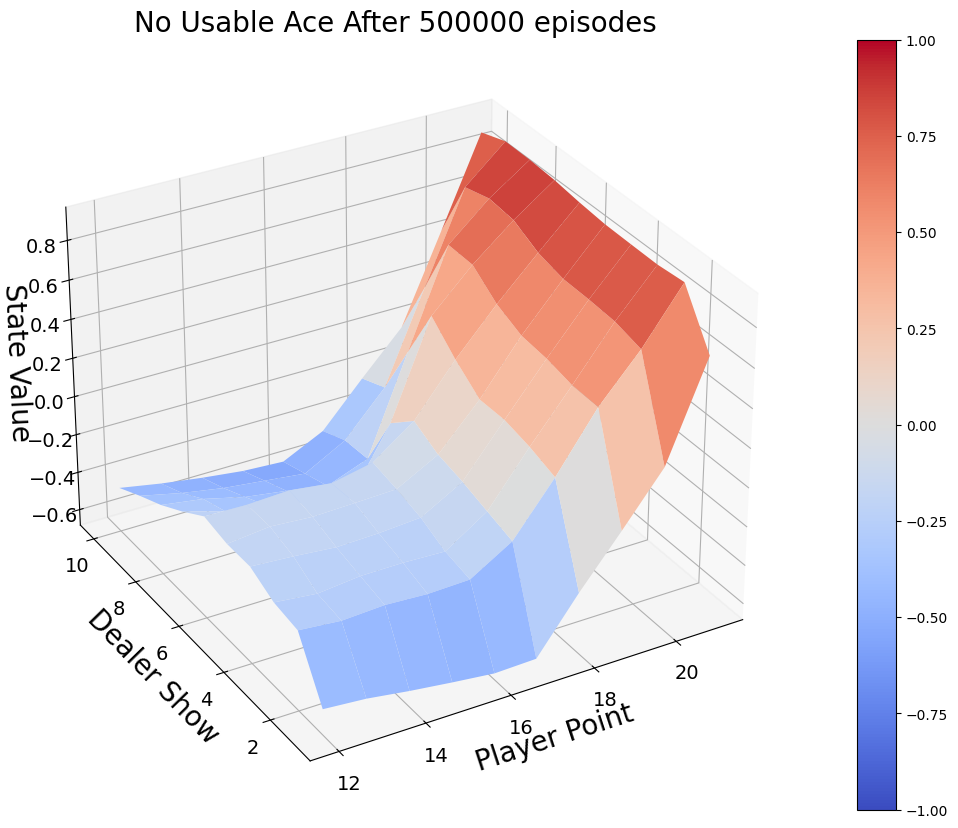

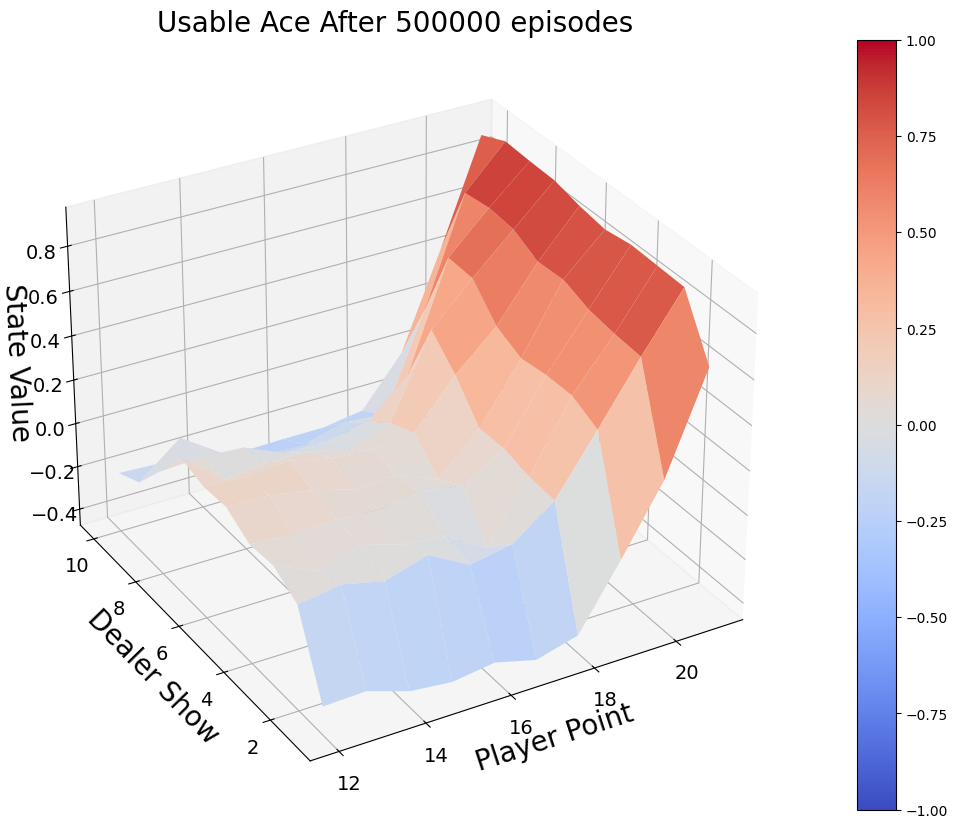

In [95]:
if __name__ == "__main__":
    n = 500000
    discount = 1   
    epsilon = 0.1
    mc_control(env, discount, epsilon, n)
    Vs = defaultdict(float)
    for state, actions in Q.items(): #actions = [action1-value, action2-value]
        action_value = np.max(actions)
        Vs[state] = action_value
    plot_value_function(Vs, n, title="Optimal Value Function")